In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.special import gamma

import sys
import os
import copy
sys.path.append("/home/alex/Dropbox/smc_hmc/python_smchmc/")
sys.path.append("../help/")
from smc_sampler_functions.functions_smc_help import sequence_distributions


# define the parameters

dim = 2

N_particles = 2**10
T_time = 50
move_steps_hmc = 20
move_steps_rw_mala = 100
ESStarget = 0.9
M_num_repetions = 1
epsilon = .5
epsilon_hmc = .1
verbose = False
targetmean = np.ones(dim)*1.
proportion = 0.3

correlation1 = 0.7*np.ones((dim, dim))
correlation2 = 0.1*np.ones((dim, dim))
np.fill_diagonal(correlation1, 1)
np.fill_diagonal(correlation2, 1)
diag_variance = np.linspace(start=1, stop=2, num=dim)
targetvariance1 = np.dot(np.diag(diag_variance**0.5), correlation1).dot(np.diag(diag_variance**0.5))
targetvariance2 = np.dot(np.diag(diag_variance**0.5), correlation2).dot(np.diag(diag_variance**0.5))

#targetvariance = ((np.diag(np.linspace(start=1, stop=2, num=dim)) +0.7*np.ones((dim, dim))))
targetvariance_inv1 = np.linalg.inv(targetvariance1)
l_targetvariance_inv1 = np.linalg.cholesky(targetvariance_inv1)
targetvariance_inv2 = np.linalg.inv(targetvariance2)
l_targetvariance_inv2 = np.linalg.cholesky(targetvariance_inv2)

parameters_mix = {'dim' : dim, 
            'N_particles' : N_particles, 
            'targetmean': targetmean, 
            'mean_shift' : np.ones(dim)*1.,
            'targetvariance1':targetvariance1,
            'targetvariance2':targetvariance2,
            'det_targetvariance1' : np.linalg.det(targetvariance1),
            'det_targetvariance2' : np.linalg.det(targetvariance2),
            'targetvariance_inv1':targetvariance_inv1,
            'targetvariance_inv2':targetvariance_inv2,
            'l_targetvariance_inv1':l_targetvariance_inv1,
            'l_targetvariance_inv2':l_targetvariance_inv2,
            'proportion' : proportion
            }

parameters1 = copy.copy(parameters_mix)
parameters1['proportion'] = 1.

parameters2 = copy.copy(parameters_mix)
parameters2['proportion'] = .0


# prepare the kernels and specify parameters
from f_rand_seq_gen import random_sequence_qmc, random_sequence_rqmc, random_sequence_mc
from smc_sampler_functions.proposal_kernels import proposalmala, proposalrw, proposalhmc, proposalhmc_parallel
from smc_sampler_functions.functions_smc_main import smc_sampler



maladict_ft = {'proposalkernel_tune': proposalmala,
                        'proposalkernel_sample': proposalmala,
                        'proposalname' : 'MALA',
                        'target_probability' : 0.65,
                        'covariance_matrix' : np.eye(dim), 
                        'L_steps' : 1,
                        'epsilon' : np.array([epsilon]),
                        'epsilon_max' : np.array([epsilon]),
                        'tune_kernel': 'fearnhead_taylor',
                        'sample_eps_L' : True,
                        'verbose' : verbose,
                        'move_steps': move_steps_rw_mala,
                        'T_time' : T_time,
                        'autotempering' : False,
                        'ESStarget': ESStarget,
                        'adaptive_covariance' : False,
                        'quantile_test': 0.1
                        }

maladict_o = {'proposalkernel_tune': proposalmala,
                        'proposalkernel_sample': proposalmala,
                        'proposalname' : 'MALA',
                        'target_probability' : 0.65,
                        'covariance_matrix' : np.eye(dim), 
                        'L_steps' : 1,
                        'epsilon' : np.array([epsilon]),
                        'epsilon_max' : np.array([epsilon]),
                        'tune_kernel': 'ours_simple',
                        'sample_eps_L' : True,
                        'verbose' : verbose,
                        'move_steps': move_steps_rw_mala,
                        'T_time' : T_time,
                        'autotempering' : False,
                        'ESStarget': ESStarget,
                        'adaptive_covariance' : False,
                        'quantile_test': 0.1
                        }


hmcdict_ft_adaptive = {'proposalkernel_tune': proposalhmc,
                    'proposalkernel_sample': proposalhmc_parallel,
                    'proposalname' : 'HMC_L_random_ft_adaptive',
                    'target_probability' : 0.9,
                    'covariance_matrix' : np.eye(dim), 
                    'L_steps' : 2.,
                    'epsilon' : np.array([epsilon_hmc]),
                    'epsilon_max' : np.array([epsilon_hmc]),
                    'accept_reject' : True,
                    'tune_kernel': 'fearnhead_taylor',
                    'sample_eps_L' : True,
                    'parallelize' : False,
                    'verbose' : verbose,
                    'move_steps': move_steps_hmc, 
                    'mean_L' : False,
                    'T_time' : T_time,
                    'autotempering' : True,
                    'ESStarget': ESStarget,
                    'adaptive_covariance' : True,
                    'quantile_test': 0.5
                    }

hmcdict_ours_adaptive = {'proposalkernel_tune': proposalhmc,
                    'proposalkernel_sample': proposalhmc_parallel,
                    'proposalname' : 'HMC_L_random_ours_adaptive',
                    'target_probability' : 0.9,
                    'covariance_matrix' : np.eye(dim), 
                    'L_steps' : 2.,
                    'epsilon' : np.array([epsilon_hmc]),
                    'epsilon_max' : np.array([epsilon_hmc]),
                    'accept_reject' : True,
                    'tune_kernel': 'ours_simple',
                    'sample_eps_L' : True,
                    'parallelize' : False,
                    'verbose' : verbose,
                    'move_steps': move_steps_hmc, 
                    'mean_L' : False,
                    'T_time' : T_time,
                    'autotempering' : True,
                    'ESStarget': ESStarget,
                    'adaptive_covariance' : True,
                    'quantile_test': 0.5
                    }



if __name__ == '__main__':

    from smc_sampler_functions.functions_smc_main import repeat_sampling
    #samplers_list_dict_adaptive = [hmcdict_ft_adaptive, hmcdict_ours_adaptive]
    samplers_list_dict_adaptive = [maladict_ft, maladict_o]

    # define the target distributions
    from smc_sampler_functions.target_distributions import targetlogdens_normal_mix, targetgradlogdens_normal_mix
    from smc_sampler_functions.target_distributions import priorlogdens_mix, priorgradlogdens_mix, priorsampler_mix


    priordistribution = {'logdensity' : priorlogdens_mix, 'gradlogdensity' : priorgradlogdens_mix, 'priorsampler': priorsampler_mix}
    targetdistribution = {'logdensity' : targetlogdens_normal_mix, 'gradlogdensity' : targetgradlogdens_normal_mix, 'target_name': 'normal_mix'}
    dict_bimodal = {'FT' : [], 'O' : []}
    dict_mode1 = {'FT' : [], 'O' : []}
    dict_mode2 = {'FT' : [], 'O' : []}
    for m in range(20):
        print('Global repetion %s'%(m))
        temperedist = sequence_distributions(parameters_mix, priordistribution, targetdistribution)
        __, res_first_iteration_adaptive_mix = repeat_sampling(samplers_list_dict_adaptive, temperedist,  parameters_mix, M_num_repetions=M_num_repetions, save_res=False, save_name = targetdistribution['target_name'], seed=m)
        dict_bimodal['FT'].append(res_first_iteration_adaptive_mix[0]['last_epsilon'])
        dict_bimodal['O'].append(res_first_iteration_adaptive_mix[1]['last_epsilon'])
        

        temperedist = sequence_distributions(parameters1, priordistribution, targetdistribution)
        __, res_first_iteration_adaptive_1 = repeat_sampling(samplers_list_dict_adaptive, temperedist,  parameters1, M_num_repetions=M_num_repetions, save_res=False, save_name = targetdistribution['target_name'], seed=m)
        dict_mode1['FT'].append(res_first_iteration_adaptive_1[0]['last_epsilon'])
        dict_mode1['O'].append(res_first_iteration_adaptive_1[1]['last_epsilon'])
        
        temperedist = sequence_distributions(parameters2, priordistribution, targetdistribution)
        __, res_first_iteration_adaptive_2 = repeat_sampling(samplers_list_dict_adaptive, temperedist,  parameters2, M_num_repetions=M_num_repetions, save_res=False, save_name = targetdistribution['target_name'], seed=m)
        dict_mode2['FT'].append(res_first_iteration_adaptive_2[0]['last_epsilon'])
        dict_mode2['O'].append(res_first_iteration_adaptive_2[1]['last_epsilon'])

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Global repetion 0
repetition 0 of 1
Now runing smc sampler with MALA kernel
Sampler ended at time 1399 after 5.65207719803 seconds 

Now runing smc sampler with MALA kernel


/home/alex/Dropbox/smc_hmc/python_smchmc/smc_sampler_functions/target_distributions.py:128: RuntimeWarning: invalid value encountered in divide
  return numerator/denominator
/home/alex/Dropbox/smc_hmc/python_smchmc/smc_sampler_functions/target_distributions.py:107: RuntimeWarning: divide by zero encountered in log
  return np.log(proportion*multivariate_normal.pdf(particles, mean=mean1, cov=parameters['targetvariance1'])+(1.-proportion)*multivariate_normal.pdf(particles, mean=mean2, cov=parameters['targetvariance2']))
/home/alex/Dropbox/smc_hmc/python_smchmc/smc_sampler_functions/proposal_kernels.py:104: RuntimeWarning: invalid value encountered in less
  accept_reject_selector = np.log(u_accept) < mh_ratio


discard nan in energy
Sampler ended at time 390 after 3.29014992714 seconds 

repetition 0 of 1
Now runing smc sampler with MALA kernel
Sampler ended at time 1423 after 5.04333806038 seconds 

Now runing smc sampler with MALA kernel
discard nan in energy
discard nan in energy
discard nan in energy
Sampler ended at time 498 after 4.21754407883 seconds 

repetition 0 of 1
Now runing smc sampler with MALA kernel
Sampler ended at time 1213 after 4.29796910286 seconds 

Now runing smc sampler with MALA kernel
discard nan in energy
discard nan in energy
Sampler ended at time 291 after 3.10299706459 seconds 

Global repetion 1
repetition 0 of 1
Now runing smc sampler with MALA kernel
Sampler ended at time 1460 after 5.2598490715 seconds 

Now runing smc sampler with MALA kernel
discard nan in energy
discard nan in energy
Sampler ended at time 390 after 3.55811595917 seconds 

repetition 0 of 1
Now runing smc sampler with MALA kernel
Sampler ended at time 1452 after 5.11857199669 seconds 

Now

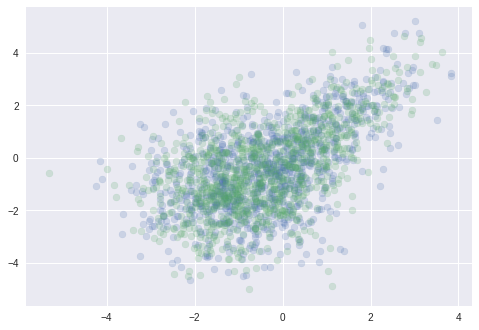

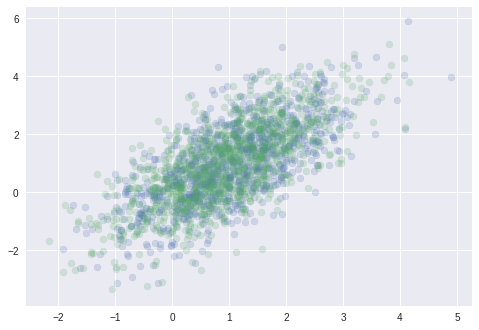

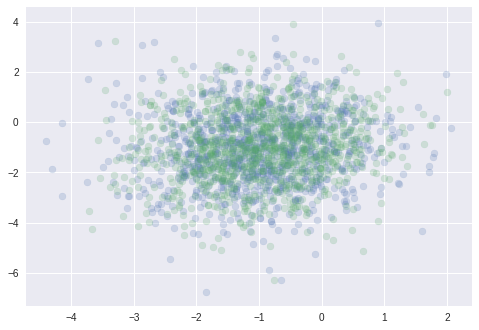

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(x=res_first_iteration_adaptive_mix[0]['particles_resampled'][:,0], y=res_first_iteration_adaptive_mix[0]['particles_resampled'][:,-1], alpha=0.2)
plt.scatter(x=res_first_iteration_adaptive_mix[1]['particles_resampled'][:,0], y=res_first_iteration_adaptive_mix[1]['particles_resampled'][:,-1], alpha=0.2)
plt.show()

plt.scatter(x=res_first_iteration_adaptive_1[0]['particles_resampled'][:,0], y=res_first_iteration_adaptive_1[0]['particles_resampled'][:,-1], alpha=0.2)
plt.scatter(x=res_first_iteration_adaptive_1[1]['particles_resampled'][:,0], y=res_first_iteration_adaptive_1[1]['particles_resampled'][:,-1], alpha=0.2)
plt.show()

plt.scatter(x=res_first_iteration_adaptive_2[0]['particles_resampled'][:,0], y=res_first_iteration_adaptive_2[0]['particles_resampled'][:,-1], alpha=0.2)
plt.scatter(x=res_first_iteration_adaptive_2[1]['particles_resampled'][:,0], y=res_first_iteration_adaptive_2[1]['particles_resampled'][:,-1], alpha=0.2)
plt.show()

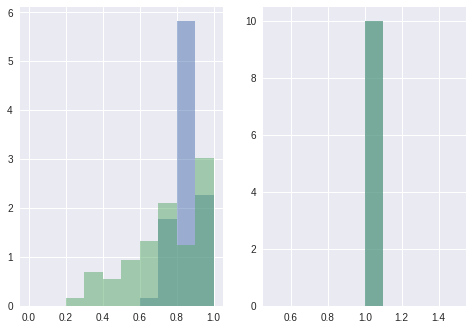

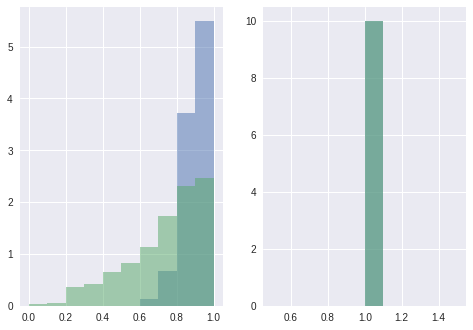

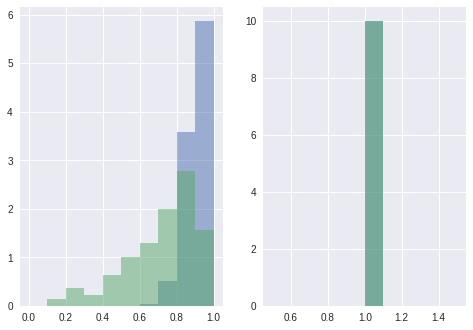

In [3]:
plt.figure()
plt.subplot(121)
plt.hist(res_first_iteration_adaptive_mix[0]['last_epsilon'], range=[0., 1.], alpha=0.5, normed=1)
plt.hist(res_first_iteration_adaptive_mix[1]['last_epsilon'], range=[0., 1.],alpha=0.5, normed=1)
plt.subplot(122)
plt.hist(res_first_iteration_adaptive_mix[0]['last_L'], alpha=0.5, normed=1)
plt.hist(res_first_iteration_adaptive_mix[1]['last_L'], alpha=0.5, normed=1); plt.show()


plt.figure()
plt.subplot(121)
plt.hist(res_first_iteration_adaptive_1[0]['last_epsilon'], range=[0., 1.], alpha=0.5, normed=1)
plt.hist(res_first_iteration_adaptive_1[1]['last_epsilon'], range=[0., 1.], alpha=0.5, normed=1)
plt.subplot(122)
plt.hist(res_first_iteration_adaptive_1[0]['last_L'], alpha=0.5, normed=1)
plt.hist(res_first_iteration_adaptive_1[1]['last_L'], alpha=0.5, normed=1); plt.show()

plt.figure()
plt.subplot(121)
plt.hist(res_first_iteration_adaptive_2[0]['last_epsilon'], range=[0., 1.], alpha=0.5, normed=1)
plt.hist(res_first_iteration_adaptive_2[1]['last_epsilon'], range=[0., 1.], alpha=0.5, normed=1)
plt.subplot(122)
plt.hist(res_first_iteration_adaptive_2[0]['last_L'], alpha=0.5, normed=1)
plt.hist(res_first_iteration_adaptive_2[1]['last_L'], alpha=0.5, normed=1); plt.show()


#sns.distplot(res_first_iteration_adaptive[0]['last_epsilon'])
#sns.distplot(res_first_iteration_adaptive[1]['last_epsilon']); plt.show()

#sns.distplot(res_first_iteration_adaptive[0]['last_L'])
#sns.distplot(res_first_iteration_adaptive[1]['last_L']); plt.show()

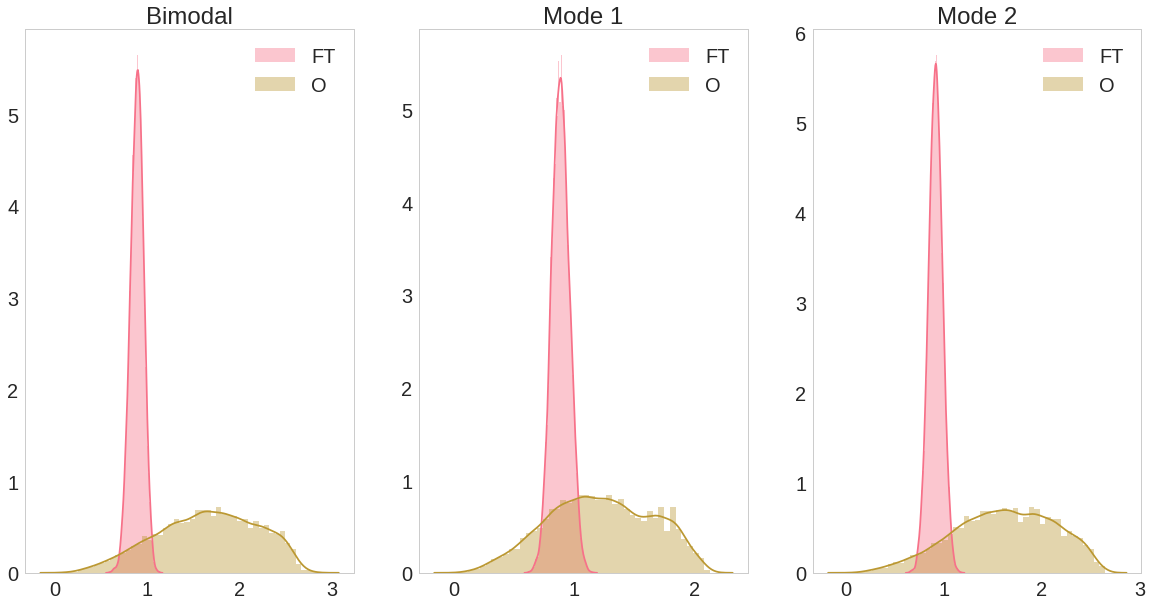

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)  
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_palette("husl")
sns.set_palette("husl")


#import matplotlib
#matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', size=32)   
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('Bimodal')
#plt.hist(np.array(dict_bimodal['FT']).flatten(), range=[0., 2.], alpha=0.5, normed=1, label='FT', bins="auto")
#plt.hist(np.array(dict_bimodal['O']).flatten(), range=[0., 2.],alpha=0.5, normed=1, label='O', bins="auto")

sns.distplot(np.array(dict_bimodal['FT']).flatten(), label='FT')# bins="auto")
sns.distplot(np.array(dict_bimodal['O']).flatten(),label='O')#, bins="auto")

plt.legend()

plt.subplot(132)
plt.title('Mode 1')
#plt.hist(np.array(dict_mode1['FT']).flatten(), range=[0., 3.], alpha=0.5, normed=1, label='FT', bins="auto")
#plt.hist(np.array(dict_mode1['O']).flatten(), range=[0., 3.], alpha=0.5, normed=1, label='O', bins="auto")

sns.distplot(np.array(dict_mode1['FT']).flatten(), label='FT')# bins="auto")
sns.distplot(np.array(dict_mode1['O']).flatten(),label='O')#, bins="auto")

plt.legend()

plt.subplot(133)
plt.title('Mode 2')
#plt.hist(np.array(dict_mode2['FT']).flatten(), range=[0., 3.], alpha=0.5, normed=1, label='FT', bins="auto")
#plt.hist(np.array(dict_mode2['O']).flatten(), range=[0., 3.], alpha=0.5, normed=1, label='O', bins="auto")

sns.distplot(np.array(dict_mode2['FT']).flatten(), label='FT')# bins="auto")
sns.distplot(np.array(dict_mode2['O']).flatten(),label='O')#, bins="auto")
plt.legend()
plt.savefig('dist_epsilon_bimodal.png')
plt.show()



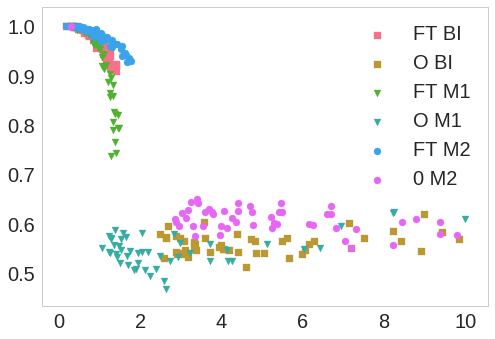

In [5]:
plt.scatter(x=res_first_iteration_adaptive_mix[0]['ESJD'], y=res_first_iteration_adaptive_mix[0]['acceptance_rate_list'], marker='s', label='FT BI')
plt.scatter(x=res_first_iteration_adaptive_mix[1]['ESJD'], y=res_first_iteration_adaptive_mix[1]['acceptance_rate_list'], marker='s', label='O BI')

plt.scatter(x=res_first_iteration_adaptive_1[0]['ESJD'], y=res_first_iteration_adaptive_1[0]['acceptance_rate_list'], marker='v', label='FT M1')
plt.scatter(x=res_first_iteration_adaptive_1[1]['ESJD'], y=res_first_iteration_adaptive_1[1]['acceptance_rate_list'], marker='v', label='O M1')

plt.scatter(x=res_first_iteration_adaptive_2[0]['ESJD'], y=res_first_iteration_adaptive_2[0]['acceptance_rate_list'], label='FT M2')
plt.scatter(x=res_first_iteration_adaptive_2[1]['ESJD'], y=res_first_iteration_adaptive_2[1]['acceptance_rate_list'], label='0 M2')
plt.legend()
; plt.show()

In [3]:
np.array(dict_bimodal['FT'])

array([[ 0.68668131,  0.33564016,  0.2858221 , ...,  0.22874878,
         0.36956398,  0.2099367 ],
       [ 0.4853413 ,  0.56184405,  0.68865388, ...,  0.20590637,
         0.24567714,  0.19904884],
       [ 0.0692168 ,  0.29905259,  0.43861513, ...,  0.40393798,
         0.27292593,  0.60537434],
       [ 0.12123178,  0.67018539,  0.78802717, ...,  0.33312292,
         0.31171767,  0.06043017],
       [ 0.82190748,  0.47022305,  0.61945963, ...,  0.36234841,
         0.75227247,  0.35327897]])